# Emotions Classifier

In [1]:
import tensorflow as tf
import os

### Avoid OOM error by setting GPU memory consumption growth

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Remove Dodgy Images

In [3]:
import cv2
import imghdr

In [4]:
data_dir = 'data'
os.listdir(data_dir)

['happy', '.DS_Store', 'sad', 'neutral', 'angry', 'confuse']

In [5]:
image_exists = ['jpeg', 'png', 'jpg', 'bmp']

In [8]:
for image_class in os.listdir(data_dir):
    if(image_class == '.DS_Store'):
        continue
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exists:
                print("Image is not in text lsit f{}".format(image_path))                
                os.remove(image_path)
        except Exception as e:
            print("Issue with Image f{}".format(image_path))

Image is not in text lsit fdata/happy/.DS_Store
Image is not in text lsit fdata/neutral/penelope_human_head_neutral_au0_square copy.jpg
Image is not in text lsit fdata/neutral/ng-latin-man-with-natural-and-neutral-face-expression-with-beard-and-dark-ha.jpg
Image is not in text lsit fdata/neutral/.DS_Store
Image is not in text lsit fdata/neutral/close-headshot-young-caucasian-man-260nw-1487254088 copy.jpg
Image is not in text lsit fdata/neutral/lightfieldstudios170805421.jpg
Image is not in text lsit fdata/neutral/facestmuli copy.jpg
Image is not in text lsit fdata/neutral/Neutral-scan-teeth-left-two-images-NURBS-model-right-two_W640 copy.jpg
Image is not in text lsit fdata/neutral/studio-closeup-portrait-blond-mature-260nw-1719144025 copy.jpg
Image is not in text lsit fdata/neutral/face-beautiful-young-redhead-girl-260nw-792993208 copy.jpg
Image is not in text lsit fdata/neutral/mature-african-woman-portrait-confident-260nw-2054809925 copy.jpg
Image is not in text lsit fdata/neutral/63

libpng warning: iCCP: known incorrect sRGB profile


## Load Data using Tensorflow Dataset

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import holoviews as hv
from PIL import Image
import seaborn as sns 

In [25]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 750 files belonging to 5 classes.
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-12-17 21:53:57.629415: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-17 21:53:57.630650: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [114]:
data_iterator = data.as_numpy_iterator()

In [115]:
batch = data_iterator.next()

2022-12-17 22:55:38.526867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


In [29]:
len(batch)

2

Here batch[0] will be images and batch[1] will be label
- 32 are images saved in every batch
- 256 x 256 is size of image
- 3 is color channels (RGB)

In [36]:
batch[0].shape

(32, 256, 256, 3)

In [31]:
batch[1]

array([0, 4, 0, 3, 2, 0, 1, 1, 2, 2, 1, 4, 0, 2, 1, 3, 0, 4, 3, 2, 0, 2,
       3, 0, 3, 0, 3, 4, 3, 2, 4, 2], dtype=int32)

In [34]:
len(batch[1])

32

### labels
- 0 = angry
- 1 = confuse
- 2 = happy
- 3 = neutral
- 4 = sad

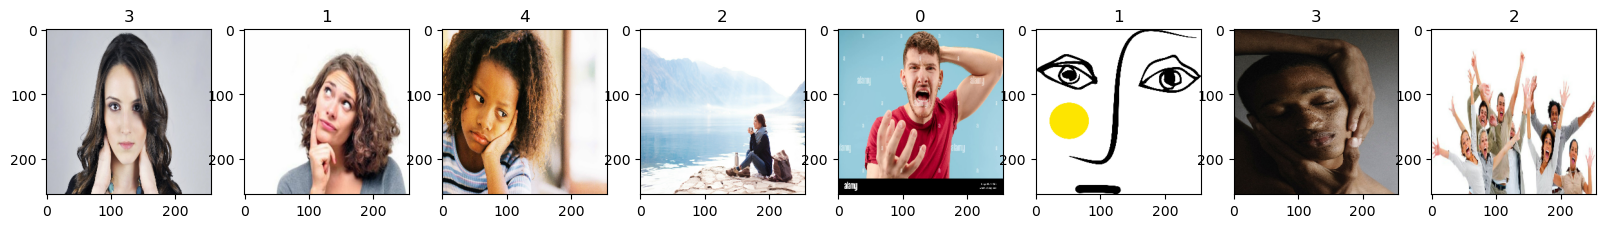

In [66]:
# batch = data_iterator.next()

fig, ax = plt.subplots(ncols=8, figsize=(20,20))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

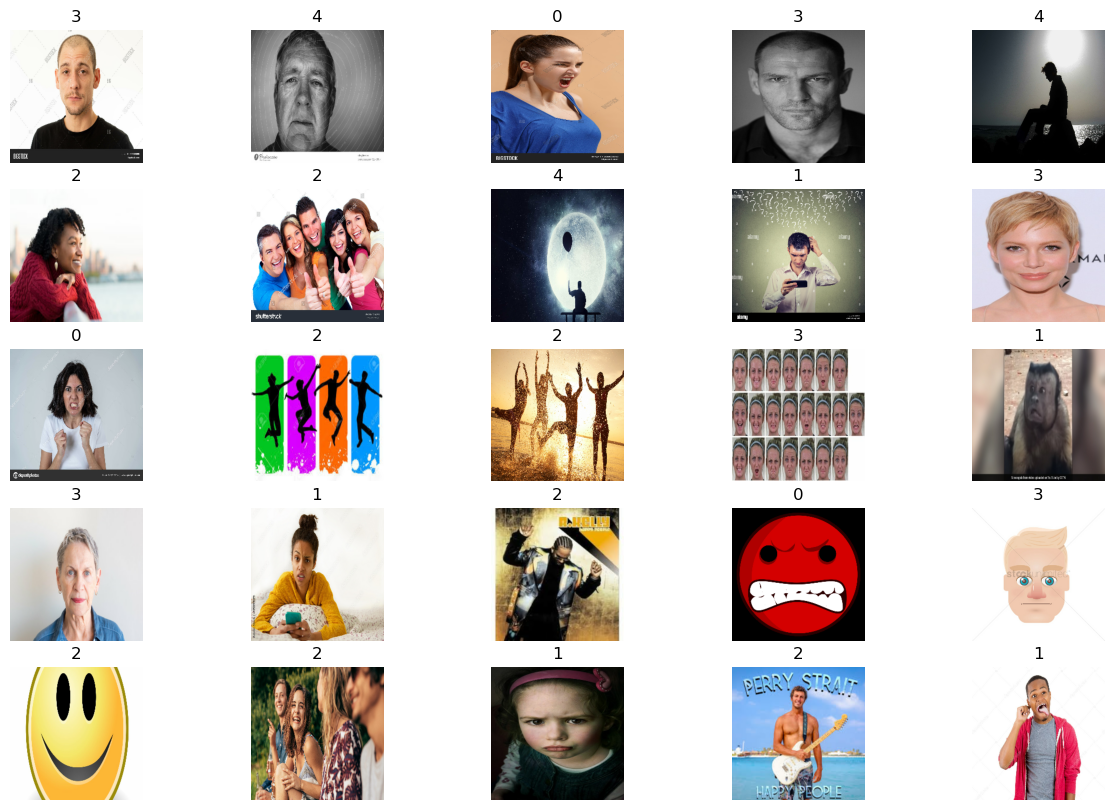

In [116]:
# batch = data_iterator.next()

def plot_images(img, labels):
    plt.figure(figsize=[15, 10])
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(img[i])
        plt.title(labels[i])
        plt.axis('off')
 
plot_images(batch[0],batch[1])

### Pre-Processing Data

In [69]:
print(batch[0].min() ,"    ", batch[0].max())

0.0      255.0


- Minimum value = 0 && Maximum value = 1
- Datavalue should be as small as possible to make Neural Netowrk optimize
- Divide every value  with Maximum value (i.e- 255) to get value range(0,1)

In [70]:
scaled = batch[0]/255

## Process Data

In [72]:
data = data.map(lambda x,y: (x/255, y))

In [117]:
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()

2022-12-17 22:56:01.751072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


In [118]:
batch = scaled_iterator.next()

In [119]:
batch[0].max()

1.0

## Train-Test-Validation Data Split

In [82]:
len(data)

24

In [101]:
train_size = (len(data)*.7)         # 70% of data
val_size = (len(data)*.2)           # 20% of data
test_size = (len(data)*.1)          # 10% of data

In [102]:
train = data.take(int(train_size))
val = data.skip(int(test_size)).take(int(val_size))
test = data.skip(int(test_size + val_size)).take(int(test_size))


## Building Deep Learning Model

In [152]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [164]:
model = Sequential()

In [165]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [175]:
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [176]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 30, 30, 16)      

In [172]:
logdir='logs'

In [177]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [178]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


2022-12-17 23:28:04.639695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-17 23:28:05.219004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/16 [==============================] - ETA: 0s - loss: 1.9722 - accuracy: 0.1836

2022-12-17 23:28:08.846984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-17 23:28:09.377747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/16 [==============================] - 7s 303ms/step - loss: 1.9722 - accuracy: 0.1836 - val_loss: 1.5910 - val_accuracy: 0.3203
Epoch 2/20


2022-12-17 23:28:11.789105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/16 [==============================] - ETA: 0s - loss: 1.5591 - accuracy: 0.2988

2022-12-17 23:28:15.591473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/16 [==============================] - 6s 311ms/step - loss: 1.5591 - accuracy: 0.2988 - val_loss: 1.4846 - val_accuracy: 0.3906
Epoch 3/20


2022-12-17 23:28:17.875494: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/16 [==============================] - ETA: 0s - loss: 1.4430 - accuracy: 0.4316

2022-12-17 23:28:21.738535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/16 [==============================] - 6s 321ms/step - loss: 1.4430 - accuracy: 0.4316 - val_loss: 1.3233 - val_accuracy: 0.5547
Epoch 4/20


2022-12-17 23:28:24.149725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/16 [==============================] - ETA: 0s - loss: 1.2457 - accuracy: 0.5020

2022-12-17 23:28:27.957919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/16 [==============================] - 6s 306ms/step - loss: 1.2457 - accuracy: 0.5020 - val_loss: 1.0660 - val_accuracy: 0.5938
Epoch 5/20


2022-12-17 23:28:30.303712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/16 [==============================] - ETA: 0s - loss: 1.0026 - accuracy: 0.6152

2022-12-17 23:28:34.104654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/16 [==============================] - 6s 315ms/step - loss: 1.0026 - accuracy: 0.6152 - val_loss: 0.8361 - val_accuracy: 0.7344
Epoch 6/20


2022-12-17 23:28:36.449189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/16 [==============================] - ETA: 0s - loss: 0.8415 - accuracy: 0.6816

2022-12-17 23:28:40.280108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/16 [==============================] - 6s 319ms/step - loss: 0.8415 - accuracy: 0.6816 - val_loss: 0.5667 - val_accuracy: 0.8359
Epoch 7/20


2022-12-17 23:28:42.773433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/16 [==============================] - ETA: 0s - loss: 0.6042 - accuracy: 0.7910

2022-12-17 23:28:46.558218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/16 [==============================] - 6s 305ms/step - loss: 0.6042 - accuracy: 0.7910 - val_loss: 0.3364 - val_accuracy: 0.8984
Epoch 8/20


2022-12-17 23:28:48.759615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/16 [==============================] - ETA: 0s - loss: 0.4560 - accuracy: 0.8574

2022-12-17 23:28:52.489922: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/16 [==============================] - 6s 301ms/step - loss: 0.4560 - accuracy: 0.8574 - val_loss: 0.2523 - val_accuracy: 0.9688
Epoch 9/20


2022-12-17 23:28:54.707125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/16 [==============================] - ETA: 0s - loss: 0.2852 - accuracy: 0.9141

2022-12-17 23:28:58.398154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/16 [==============================] - 6s 296ms/step - loss: 0.2852 - accuracy: 0.9141 - val_loss: 0.1911 - val_accuracy: 0.9688
Epoch 10/20


2022-12-17 23:29:00.567440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/16 [==============================] - ETA: 0s - loss: 0.2866 - accuracy: 0.9297

2022-12-17 23:29:04.327390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/16 [==============================] - 6s 305ms/step - loss: 0.2866 - accuracy: 0.9297 - val_loss: 0.1494 - val_accuracy: 0.9453
Epoch 11/20


2022-12-17 23:29:06.573858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/16 [==============================] - ETA: 0s - loss: 0.1733 - accuracy: 0.9492

2022-12-17 23:29:10.382482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/16 [==============================] - 6s 311ms/step - loss: 0.1733 - accuracy: 0.9492 - val_loss: 0.0803 - val_accuracy: 0.9766
Epoch 12/20


2022-12-17 23:29:12.593639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/16 [==============================] - ETA: 0s - loss: 0.0775 - accuracy: 0.9844

2022-12-17 23:29:16.315645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/16 [==============================] - 6s 300ms/step - loss: 0.0775 - accuracy: 0.9844 - val_loss: 0.0418 - val_accuracy: 0.9844
Epoch 13/20


2022-12-17 23:29:18.499666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/16 [==============================] - ETA: 0s - loss: 0.0694 - accuracy: 0.9844

2022-12-17 23:29:22.212424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/16 [==============================] - 6s 303ms/step - loss: 0.0694 - accuracy: 0.9844 - val_loss: 0.0558 - val_accuracy: 0.9922
Epoch 14/20


2022-12-17 23:29:24.398989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/16 [==============================] - ETA: 0s - loss: 0.2309 - accuracy: 0.9570

2022-12-17 23:29:28.241790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/16 [==============================] - 6s 309ms/step - loss: 0.2309 - accuracy: 0.9570 - val_loss: 0.3154 - val_accuracy: 0.9531
Epoch 15/20


2022-12-17 23:29:30.446569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/16 [==============================] - ETA: 0s - loss: 0.2444 - accuracy: 0.9512

2022-12-17 23:29:34.227612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/16 [==============================] - 6s 315ms/step - loss: 0.2444 - accuracy: 0.9512 - val_loss: 0.1981 - val_accuracy: 0.9766
Epoch 16/20


2022-12-17 23:29:36.654977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/16 [==============================] - ETA: 0s - loss: 0.1028 - accuracy: 0.9746

2022-12-17 23:29:40.629987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/16 [==============================] - 6s 322ms/step - loss: 0.1028 - accuracy: 0.9746 - val_loss: 0.0404 - val_accuracy: 1.0000
Epoch 17/20


2022-12-17 23:29:42.953961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/16 [==============================] - ETA: 0s - loss: 0.0562 - accuracy: 0.9844

2022-12-17 23:29:46.923764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/16 [==============================] - 6s 323ms/step - loss: 0.0562 - accuracy: 0.9844 - val_loss: 0.0298 - val_accuracy: 0.9922
Epoch 18/20


2022-12-17 23:29:49.268741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/16 [==============================] - ETA: 0s - loss: 0.0218 - accuracy: 0.9922

2022-12-17 23:29:53.053473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/16 [==============================] - 6s 305ms/step - loss: 0.0218 - accuracy: 0.9922 - val_loss: 0.0086 - val_accuracy: 1.0000
Epoch 19/20


2022-12-17 23:29:55.258258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/16 [==============================] - ETA: 0s - loss: 0.0548 - accuracy: 0.9922

2022-12-17 23:29:59.027191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/16 [==============================] - 6s 312ms/step - loss: 0.0548 - accuracy: 0.9922 - val_loss: 0.0154 - val_accuracy: 1.0000
Epoch 20/20


2022-12-17 23:30:01.371464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/16 [==============================] - ETA: 0s - loss: 0.0269 - accuracy: 0.9922

2022-12-17 23:30:05.192618: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/16 [==============================] - 6s 309ms/step - loss: 0.0269 - accuracy: 0.9922 - val_loss: 0.0435 - val_accuracy: 0.9922
